# Import packages

In [ ]:
!gsutil cp gs://tactile-paving-bucket/train_images.zip train_images.zip
!gsutil cp gs://tactile-paving-bucket/test_images.zip test_images.zip

!unzip train_images.zip -d train_images
!unzip test_images.zip -d test_images

!rm -rf train_images.zip
!rm -rf test_images.zip

In [ ]:
!pip install transformers
!pip install torch
!pip install torchvision
!pip install timm
!pip install pycocotools
!pip install tensorboard

In [1]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
import json
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import gc

In [2]:
torch.cuda.is_available()

True

# Load in COCO dataset and turn into DataLoader

In [23]:
# path_to_train_data = "train_images/image" # for cloud instance
# path_to_test_data = "test_images/image"

path_to_train_data = "crowd4access-images/crowd4access-images/trainval/image" # for local
path_to_test_data = "crowd4access-images/crowd4access-images/test/image"

In [24]:
class CocoDetection(torchvision.datasets.CocoDetection):
    """
    Huge thank you to Niels Rogge, all this was written by him except for me changing filepaths
    """
    def __init__(self, img_folder: str, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [25]:
feature_extractor = DetrFeatureExtractor.from_pretrained(
    "facebook/detr-resnet-50"
    )

train_dataset = CocoDetection(img_folder=path_to_train_data, feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=path_to_test_data, feature_extractor=feature_extractor, train=False)

id2label = {k: v["name"] for k, v in train_dataset.coco.cats.items()}

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", 
    num_labels=len(id2label), 
    ignore_mismatched_sizes=True,
    num_queries=10
    )

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- model.query_position_embeddings.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [26]:
model.base_model.freeze_backbone()

Image 449


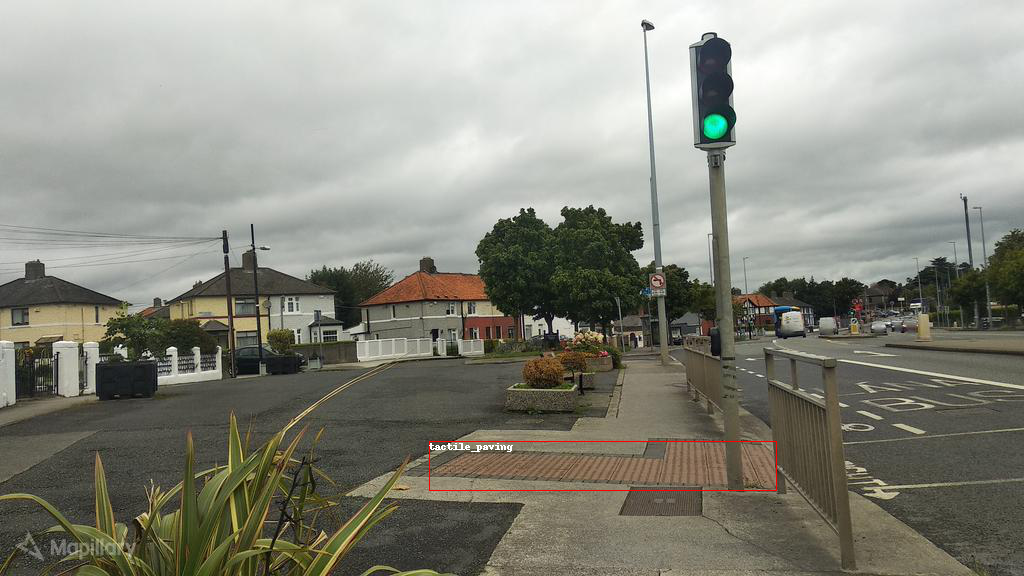

In [27]:
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print(f'Image {image_id}')
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(path_to_train_data, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [28]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]

    encoding = feature_extractor.pad_and_create_pixel_mask(
        pixel_values,
        return_tensors="pt"
    )
    
    labels = [item[1] for item in batch]

    batch = {}

    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    
    return batch

In [29]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=2,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_fn,
    batch_size=2
)

# Training!

In [10]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 100
num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps
# )
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

progress_bar = tqdm(range(num_training_steps))

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/90100 [00:00<?, ?it/s]

In [11]:
device

device(type='cuda')

In [12]:
torch.cuda.empty_cache()
# del train_dataset
# del test_dataset
gc.collect()

1190

In [15]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
path_to_weights = "detr_tactile-paving"
experiment_name = "unfreeze_after_keep_layers_frozen"
writer = SummaryWriter(os.path.join("runs", experiment_name))

for param in model.base_model.parameters():
    param.requires_grad = True

# best_vloss = 1000
for epoch in range(num_epochs):
    # if epoch in range(0, 30): # freeze all layers except custom head for some epochs
    #     for param in model.base_model.parameters():
    #         param.requires_grad = False
    # else:
    #     for param in model.base_model.parameters():
    #         param.requires_grad = True

    # training loop
    model.train(True)
    running_loss = 0.
    for i, batch in enumerate(train_dataloader):
        
        pixel_values = batch["pixel_values"]
        pixel_values = pixel_values.to(device)
        pixel_mask = batch["pixel_mask"]
        pixel_mask = pixel_mask.to(device)
        labels = []

        for label in batch["labels"]:
            labels.append({k: v.to(device) for k, v in label.items()})

        optimizer.zero_grad()

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels
        )
        loss_dict = outputs.loss_dict
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        progress_bar.update(1)
        
    # validation
    model.train(False)
    running_vloss = 0.
    for j, batch in enumerate(val_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        # pixel_values = pixel_values.to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        # pixel_mask = pixel_mask.to(device)
        labels = []

        for label in batch["labels"]:
            labels.append({k: v.to(device) for k, v in label.items()})

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels
        )
        val_loss_dict = outputs.loss_dict
        val_loss = outputs.loss
        running_vloss += loss.item()

    avg_loss = running_loss / (i + 1)
    avg_vloss = running_vloss / (j + 1)

    # log results
    writer.add_scalar("train_avg_loss", avg_loss, epoch)
    writer.add_scalar("val_avg_loss", avg_vloss, epoch)

    for k,v in loss_dict.items(): # reports last train loss
          writer.add_scalar("train_" + k, v.item(), epoch)
            
    for k,v in val_loss_dict.items(): # reports last val loss
        writer.add_scalar("val_" + k, v.item(), epoch)
        
    writer.flush()
    
    # simplest early stopping mechanism you've ever seen
    if avg_vloss < best_vloss:
        better_idx = epoch
        best_vloss = avg_vloss
        print("Better val loss found! Updating...")
        model.save_pretrained(path_to_weights)
    # elif epoch > better_idx + 5: # if vloss doesn't improve for 5 epochs, stop training
    #     print("Early stopping engaged. Average val loss hasn't improved for 3 epochs. Reverting to best model")
    #     break

writer.close()

Better val loss found! Updating...


KeyboardInterrupt: 

Move run logs and model weights to GCP bucket to download locally

In [ ]:
!gsutil cp -r runs gs://tactile-paving-bucket/runs
!gsutil cp -r detr_tactile-paving gs://tactile-paving-bucket/detr_tactile-paving

Copying file://runs/unfreeze_after_keep_layers_frozen/events.out.tfevents.1647031751.tactile-paving.3666.1 [Content-Type=application/octet-stream]...
Copying file://runs/Mar07_18-43-47_tactile-paving/events.out.tfevents.1646678627.tactile-paving.2667.2 [Content-Type=application/octet-stream]...
Copying file://runs/Mar08_22-07-59_tactile-paving/events.out.tfevents.1646777279.tactile-paving.3394.0 [Content-Type=application/octet-stream]...
Copying file://runs/Mar07_18-43-09_tactile-paving/events.out.tfevents.1646678589.tactile-paving.2667.1 [Content-Type=application/octet-stream]...
/ [4 files][ 37.1 KiB/ 37.1 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://runs/Mar09_00-10-45_tactile-paving/events.out.tfevents.164678464